#### Ejemplos con BertTokenizer

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random
# from collections import Counter
# from datasets import load_dataset
import pandas as pd

In [22]:
#!wget 'https://raw.githubusercontent.com/LeoBrasileo/Aprendizaje-Automatico-TP2/refs/heads/main/py/funciones_dataset.py'
#!wget 'https://github.com/LeoBrasileo/Aprendizaje-Automatico-TP2/raw/refs/heads/main/py/marquez_clean.py'
#!wget 'https://github.com/LeoBrasileo/Aprendizaje-Automatico-TP2/raw/refs/heads/main/py/token_embeddings.py'

In [23]:
from funciones_dataset import ETIQUETAS_PUNT_INICIAL, ETIQUETAS_PUNT_FINAL, ETIQUETAS_CAPITALIZACION

In [24]:
url = 'https://github.com/LeoBrasileo/Aprendizaje-Automatico-TP2/raw/refs/heads/main/data/datos_google_argento.csv'
df_google_arg = pd.read_csv(url, sep=',', index_col=False)
df_google_arg.head()

,texto_original,texto_limpio
0,"Para la caída del cabello, tengo un nuevo champú",para la caída del cabello tengo un nuevo champú
1,Los hámsters comen zanahorias,los hámsters comen zanahorias
2,¿Me podés mandar fotos de la pileta?,me podés mandar fotos de la pileta
3,Hola Cristina que bueno que pueda hablar con vos,hola cristina que bueno que pueda hablar con vos
4,Tranquilo va a estar todo bien,tranquilo va a estar todo bien


Declaramos a nuestro tokenizer como el tokenizer de Bert

In [25]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# Defino el tamaño del vocabulario como el tamaño del vocabulario default de bert-base-multilingual-cased,
# Esto se usaría en las capas de embeddings, como dimensión. 
VOCAB_SIZE = tokenizer.vocab_size

In [26]:
original = '¿A qué hora vamos a McDonalds?'
texto = "a qué hora vamos a mcdonalds"
tokens = tokenizer.tokenize(texto)
tokens_orig = tokenizer.tokenize(original)

print(tokens)
print(tokens_orig)

['a', 'qué', 'hora', 'va', '##mos', 'a', 'm', '##c', '##dona', '##ld', '##s']
['¿', 'A', 'qué', 'hora', 'va', '##mos', 'a', 'McDonald', '##s', '?']


In [27]:
print(tokenizer.convert_tokens_to_ids(tokens))

[169, 38188, 24301, 10321, 13386, 169, 181, 10350, 64674, 12620, 10107]


### Limpieza de strings

In [28]:
vocales_con_acento_min = [chr(x) for x in [ord('á'), ord('é'), ord('í'), ord('ó'), ord('ú')]]
vocales_con_acento_may = [chr(x) for x in [ord('Á'), ord('É'), ord('Í'), ord('Ó'), ord('Ú')]]
allowed_characters = [chr(x) for x in range(97,123)] + vocales_con_acento_min + [chr(241)] + [chr(10), chr(32)] + [chr(x) for x in range(48,58)] # los caracteres de letras minúsculas, espacio en blanco y fin de linea y números
characters_to_replace = [chr(x) for x in range(65,91)] + vocales_con_acento_may + [chr(209)] #las mayúsculas
characters_to_replace_with = [chr(x) for x in range(97,123)] + vocales_con_acento_min + [chr(241)] #las minúsculas
replace_dict = dict(zip(characters_to_replace, characters_to_replace_with))

def limpiar_string (s) :
  res = ""
  for c in s :
    if c in allowed_characters :
      res += c
    elif c in characters_to_replace :
      res += replace_dict[c]
  return res

In [29]:
test_limpieza = "Veamos que pasa si cortamos un árbol ¿Será capaz de entender? El Árbol no sentirá el corte hasta que sea demaisado tarde: al buscar sus raices para nutrir las hojas, sentirá la desesperación de la falta." + '\n' + '¡Ósado el talador, que se preocupa más por el calor de su morada que la protección que ofrece el bosque y la protección de todas sus criaturas contra el silencio verdadero!'
print(test_limpieza)
print('\n')
print(limpiar_string(test_limpieza))

Veamos que pasa si cortamos un árbol ¿Será capaz de entender? El Árbol no sentirá el corte hasta que sea demaisado tarde: al buscar sus raices para nutrir las hojas, sentirá la desesperación de la falta.
¡Ósado el talador, que se preocupa más por el calor de su morada que la protección que ofrece el bosque y la protección de todas sus criaturas contra el silencio verdadero!


veamos que pasa si cortamos un árbol será capaz de entender el árbol no sentirá el corte hasta que sea demaisado tarde al buscar sus raices para nutrir las hojas sentirá la desesperación de la falta
ósado el talador que se preocupa más por el calor de su morada que la protección que ofrece el bosque y la protección de todas sus criaturas contra el silencio verdadero


### Etiquetas para datos de entrada

**Nota**: es un planteo preliminar, imitando cómo nos piden entregar las respuestas, se pueden hacer modificaciones para lo que necesitemos como entrada

In [30]:
import pandas as pd
from funciones_dataset import asignar_etiquetas_puntuacion, asignar_puntuacion_a_tokens

##### Ejemplo 1:

Primero definimos puntuación para los tokens

Este ejemplo, usando el - , no anda

In [31]:
texto_original = "¿Cuándo vamos a McDonald's?Ellos no vienen. Entonces, - ¿dónde están?"

texto_limpio = limpiar_string(texto_original)
tokens_texto_limpio = tokenizer.tokenize(texto_limpio)

puntuacion_tokens = asignar_puntuacion_a_tokens(instancia_original=texto_original,
                                                instancia_id=1,
                                                instancia_tokens=tokens_texto_limpio)
pd.DataFrame.from_dict(puntuacion_tokens)

,instancia_id,token,token_id,capitalizacion,puntuacion_inicial,puntuacion_final
0,1,cu,10854,1,¿,
1,1,##ánd,101439,1,,
2,1,##o,10133,1,,
3,1,va,10321,0,,
4,1,##mos,13386,0,,
5,1,a,169,0,,
6,1,m,181,2,,
7,1,##c,10350,2,,
8,1,##dona,64674,2,,
9,1,##ld,12620,2,,


La instancia etiquetada final (con las etiquetas definidas en _ETIQUETA_PUNT_FINAL_ y _ETIQUETA_PUNT_INICIAL_) sería de esta forma:

In [32]:
tokens_etiquetados = asignar_etiquetas_puntuacion(puntuacion_tokens)
pd.DataFrame.from_dict(tokens_etiquetados)

,instancia_id,token,token_id,capitalizacion,puntuacion_inicial,puntuacion_final
0,1,cu,10854,1,1,0
1,1,##ánd,101439,1,0,0
2,1,##o,10133,1,0,0
3,1,va,10321,0,0,0
4,1,##mos,13386,0,0,0
5,1,a,169,0,0,0
6,1,m,181,2,0,0
7,1,##c,10350,2,0,0
8,1,##dona,64674,2,0,0
9,1,##ld,12620,2,0,0


##### Ejemplo 2:

Este ejemplo anda, eliminando el -. 

In [33]:
texto_original = "¿Cuándo vamos a McDonald's? Ellos no vienen. Entonces, ¿dónde están?"

texto_limpio = limpiar_string(texto_original)
tokens_texto_limpio = tokenizer.tokenize(texto_limpio)

puntuacion_tokens = asignar_puntuacion_a_tokens(instancia_original=texto_original,
                                                instancia_id=1,
                                                instancia_tokens=tokens_texto_limpio)

tokens_etiquetados = asignar_etiquetas_puntuacion(puntuacion_tokens)

pd.DataFrame.from_dict(tokens_etiquetados)

,instancia_id,token,token_id,capitalizacion,puntuacion_inicial,puntuacion_final
0,1,cu,10854,1,1,0
1,1,##ánd,101439,1,0,0
2,1,##o,10133,1,0,0
3,1,va,10321,0,0,0
4,1,##mos,13386,0,0,0
5,1,a,169,0,0,0
6,1,m,181,2,0,0
7,1,##c,10350,2,0,0
8,1,##dona,64674,2,0,0
9,1,##ld,12620,2,0,0


##### Ejemplo 3:

In [34]:
tokens_test_limpieza = tokenizer.tokenize(limpiar_string(test_limpieza))

puntuacion_tokens = asignar_puntuacion_a_tokens(instancia_original=test_limpieza,
                                                instancia_id=1,
                                                instancia_tokens=tokens_test_limpieza)

tokens_etiquetados = asignar_etiquetas_puntuacion(puntuacion_tokens)

pd.DataFrame.from_dict(tokens_etiquetados).head(12)

,instancia_id,token,token_id,capitalizacion,puntuacion_inicial,puntuacion_final
0,1,ve,10323,1,0,0
1,1,##amos,73983,1,0,0
2,1,que,10121,0,0,0
3,1,pasa,26088,0,0,0
4,1,si,10294,0,0,0
5,1,corta,53134,0,0,0
6,1,##mos,13386,0,0,0
7,1,un,10119,0,0,0
8,1,árbol,55220,0,0,0
9,1,será,23843,1,1,0


In [35]:
#creaar DataFrame para alimentar el dataset (pensando en que va a ser mas rapido para el entrenamiento)
data_path ='https://github.com/LeoBrasileo/Aprendizaje-Automatico-TP2/raw/refs/heads/main/data/marquez_cleaned.csv'  # Remove the leading slash
data = pd.read_csv(data_path, delimiter=',')
texto_original = data['texto_original'].tolist()
# texto_limpio = data['texto_limpio'].tolist()

puntuacion_tokens_marquez = []
problematic_sentences = []

for i in range(4,len(texto_original)):
    try:
        # tokens_texto_original = tokenizer.tokenize(texto_original[i])
        texto_limpio = limpiar_string(texto_original[i])
        tokens_texto_limpio = tokenizer.tokenize(texto_limpio)

        puntuacion_tokens = asignar_puntuacion_a_tokens(instancia_original=texto_original[i],
                                                        instancia_id=i+1,
                                                        instancia_tokens=tokens_texto_limpio)
        puntuacion_tokens = asignar_etiquetas_puntuacion(puntuacion_tokens)
        puntuacion_tokens_marquez.append(puntuacion_tokens)
    except Exception as e:
        # Store problematic sentence info instead of breaking
        problematic_sentences.append({
            'index': i,
            'original_text': texto_original[i],
            'cleaned_text': texto_limpio if 'texto_limpio' in locals() else None,
            'error': str(e)
        })
        continue


print(f"funcionaron: {len(puntuacion_tokens_marquez)} sentences")
print(f"con problemas: {len(problematic_sentences)}")

# oraciones con problemas
for prob in problematic_sentences[:5]:  # Show first 5 problematic sentences
    print(f"Index {prob['index']}: {repr(prob['original_text'][:100])}... Error: {prob['error']}")


# renumerar para que los ids de instancia sean consecutivos
puntuacion_tokens_marquez_clean = []
for new_id, tokens_list in enumerate(puntuacion_tokens_marquez):
    tokens_list_updated = []
    for token_dict in tokens_list:
        token_dict_updated = token_dict.copy()
        token_dict_updated['instancia_id'] = new_id + 1  # que empiece en 1?
        tokens_list_updated.append(token_dict_updated)
    puntuacion_tokens_marquez_clean.append(tokens_list_updated)


funcionaron: 1810 sentences
con problemas: 336
Index 19: 'Si has de volverte loco, vuélvete tú solo gritó . Pero no trates de inculcar a los niños tus ideas d'... Error: string index out of range
Index 28: 'Es el olor del demonio dijo ella. En absoluto corrigió Valeria . Está comprobado que el demonio tien'... Error: string index out of range
Index 36: 'En el mundo están ocurriendo cosas increíbles le decía a Gabriel . Ahí mismo, al otro lado del río, '... Error: string index out of range
Index 51: 'No importa decía Vega . Lo esencial es no perder la orientación.'... Error: string index out of range
Index 58: 'Sus sueños terminaban frente a ese mar color de ceniza, espumoso y sucio, que no merecía los riesgos'... Error: string index out of range


# Clase del dataset de 100 Años de Soledad


In [36]:
class MarquezDataset(Dataset):
    def __init__(self, data, label_key='puntuacion_final', pad_token_id=0, pad_label_id=-100):
        """
        Args:
            data: list of sentences, each a list of dicts (one per token)
            label_key: which label to use ('puntuacion_final' or 'puntuacion_inicial')
            pad_token_id: ID used for padding tokens
            pad_label_id: label used for padding positions (-100 for CrossEntropyLoss)
        """
        self.data = data
        self.label_key = label_key
        self.pad_token_id = pad_token_id
        self.pad_label_id = pad_label_id

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence = self.data[idx]

        # Extract features
        token_ids = [tok['token_id'] for tok in sentence]
        caps = [tok['capitalizacion'] for tok in sentence]
        punt_inicial = [tok['puntuacion_inicial'] for tok in sentence]
        punt_final = [tok[self.label_key] for tok in sentence]

        return {
            'token_ids': torch.tensor(token_ids, dtype=torch.long),
            'capitalizacion': torch.tensor(caps, dtype=torch.float),
            'puntuacion_inicial': torch.tensor(punt_inicial, dtype=torch.float),
            'puntuacion_final': torch.tensor(punt_final, dtype=torch.float),
            'length': len(token_ids)
        }

def marquez_collate_fn(batch, pad_token_id=0, pad_label_id=-100):
    # Separate each field
    token_ids = [item['token_ids'] for item in batch]
    caps = [item['capitalizacion'] for item in batch]
    punt_inicial = [item['puntuacion_inicial'] for item in batch]
    punt_final = [item['puntuacion_final'] for item in batch]
    lengths = [item['length'] for item in batch]

    # Pad sequences
    padded_token_ids = nn.utils.rnn.pad_sequence(token_ids, batch_first=True, padding_value=pad_token_id)
    padded_caps = nn.utils.rnn.pad_sequence(caps, batch_first=True, padding_value=0.0)
    padded_punt_inicial = nn.utils.rnn.pad_sequence(punt_inicial, batch_first=True, padding_value=pad_label_id)
    padded_punt_final = nn.utils.rnn.pad_sequence(punt_final, batch_first=True, padding_value=pad_label_id)

    return {
        'token_ids': padded_token_ids,
        'capitalizacion': padded_caps,
        'puntuacion_inicial': padded_punt_inicial,
        'puntuacion_final': padded_punt_final,
        'lengths': torch.tensor(lengths)
    }

dataset_marquez = MarquezDataset(data=puntuacion_tokens_marquez)
loader = DataLoader(dataset_marquez, batch_size=32, shuffle=True, collate_fn=marquez_collate_fn)

# Clases para modelos

## RNN Clásica

In [37]:
class RNN_Clasica(nn.Module):
  def __init__(self, 
               hidden_size,
               embedding_dim, 
               vocab_size=VOCAB_SIZE, 
               embeddings=None,
               dropout_rate=0.5
               ):
    
    super(RNN_Clasica, self).__init__()
    
    # Si tenemos embeddings pre-entrenados, los usamos
    if embeddings:
      self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=True)
    else:
      self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

    # Dos capas LSTM 
    self.LSTM_1 = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
    self.LSTM_2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
    
    # Dropout
    self.dropout = nn.Dropout(dropout_rate)
    
    # Capas de output para las tres tareas que queremos 
    self.linear_puntuacion_inic = nn.Linear(hidden_size, 2)     # Sin puntuación || ¿
    self.linear_puntuacion_final = nn.Linear(hidden_size, 4)    # Sin puntuación || ? || , || . 
    self.linear_capitalizacion = nn.Linear(hidden_size, 4)      # minúscula || mayúscula inicial || algunas mayúsculas || toda mayúscula 

  def forward(self, x):
      x = self.embedding(x)

      x, _ = self.LSTM_1(x)
      x = self.dropout(x)
      x, _ = self.LSTM_2(x)
      x = self.dropout(x)

      # Cada bloque lineal produce logits (no probabilidades) para cada clase, en la tarea que le corresponde
      # No agrego softmax o algo del estilo porque luego usamos CrossEntropyLoss, que espera los logits.
      score_puntuacion_inic = self.linear_puntuacion_inic(x)  
      score_puntuacion_final = self.linear_puntuacion_final(x)   
      score_capitalizacion = self.linear_capitalizacion(x)           

      return score_puntuacion_inic, score_puntuacion_final, score_capitalizacion

## Modelo clásico

**TO DO**

## RNN Bidireccional

In [38]:
class RNN_Bidireccional(nn.Module):
  def __init__(self, 
               input_size, 
               hidden_size, 
               punct_class_size, 
               cap_class_size, 
               num_layers, 
               embedding_dim,
               embeddings=None,
               vocab_size=VOCAB_SIZE):
    super(RNN_Bidireccional, self).__init__()

    #si tenemos embeddings pre-entrenados, los usamos
    if embeddings:
      self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=True)
    else:
      self.embedding = nn.Embedding(input_size, hidden_size)
      ##### COMENTARIO DE BIANCA: Para mí habría que cambiar a lo que sigue (y también cambiar la rnn1 con lo que comenté abajo), ya que la nn.Embedding define la "look-up table"
      ##### self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

    #usamos dos RNNs bidireccionales, según el paper que habíamos visto
    self.rnn1 = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
    ##### self.rnn1 = nn.RNN(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=True)
    self.rnn2 = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

    #usamos dos lineales para predecir la puntuación con una y la capitalización con la otra
    ### COMENTARIO (duda) DE BIANCA: entonces las clases de puntuación son tuplas (punt inicial, punt final) = ( ¿ , ? ), (None, ","),... ? es decir tenemos 8 clases para puntuación en vez de tomarlo como dos tareas separadas? Yo en la clase de la red clásica había hecho como si fuesen 3 tareas.
    self.linear_punctuation = nn.Linear(hidden_size, punct_class_size)
    self.linear_capitalization = nn.Linear(hidden_size, cap_class_size)
    
    #funciones de activación para las capas ocultas (ReLu) y para el ouput una softmax para cada set de predicciones
    self.activation_hidden = nn.ReLU()
    self.activation_output = nn.Softmax(dim=1)

  def forward(self, x):
    #x_in : input_size, x_out : hidden_size
      x = self.embedding(x)

    #x_in : hidden_size, x_out : hidden_size
      x = self.rnn1(x)
      x = self.activation_hidden(x)
      x = self.rnn2(x)
      x = self.activation_hidden(x)

    #x_in : hidden_size, x_out : |clases puntuación| + |clases capitalización|
      x_punt = self.linear_punctuation(x)
      x_punt = self.activation_output(x_punt)

      x_cap = self.linear_capitalization(x)
      x_cap = self.activation_output(x_cap)

      return torch.cat((x_punt,x_cap), dim=0)

# Definición de modelos y entrenamiento

### Definición de modelos e hiperparámetros

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

NUM_EPOCHS = 80
LEARNING_RATE = 0.0001
EMBEDDING_DIM = 265         # De ejemplo, por ahora hasta que entrenemos la capa de embeddings. También se pueden probar distintos para c/ modelo.

In [40]:
modelo_bidireccional = RNN_Bidireccional(embedding_dim=EMBEDDING_DIM, input_size = 3, hidden_size = 700, num_layers=3, punct_class_size=8, cap_class_size=4).to(device)

print(f"Modelo de red neuronal bidireccional creado con {sum(p.numel() for p in modelo_bidireccional.parameters())} parámetros")

Modelo de red neuronal bidireccional creado con 15707312 parámetros


In [41]:
modelo_unidireccional = RNN_Clasica(hidden_size=700, embedding_dim=EMBEDDING_DIM).to(device)
optimizer_unidireccional = torch.optim.Adam(modelo_unidireccional.parameters(), lr=LEARNING_RATE)
criterion_unidireccional = nn.CrossEntropyLoss()

print(f"Modelo de red neuronal unidireccional creado con {sum(p.numel() for p in modelo_unidireccional.parameters())} parámetros")

Modelo de red neuronal unidireccional creado con 38320165 parámetros


### Funciones de entrenamiento

In [42]:
def ejecutar_epoch_entrenamiento(model, dataloader, optimizer, criterion):
    device = next(model.parameters()).device
    model.train()
    loss_total = 0

    for batch in dataloader:
        optimizer.zero_grad()

        # Cargo los datos al device que estemos utlizando (caso de estar usando GPU)
        for key in batch:
            if isinstance(batch[key], torch.Tensor):
                batch[key] = batch[key].to(device)
            
        # Paso forward
        logits_punt_inic, logits_punt_final, logits_capitalizacion = model(batch['token_ids'])

        # Reshape de los logits para CE:
        logits_punt_inic = logits_punt_inic.reshape(-1, logits_punt_inic.size(-1))
        logits_punt_final = logits_punt_final.reshape(-1, logits_punt_final.size(-1))
        logits_capitalizacion = logits_capitalizacion.reshape(-1, logits_capitalizacion.size(-1))

        # Definiendo los targets (y reshape para CE):
        target_punt_inic = batch['puntuacion_inicial'].reshape(-1).long()
        target_punt_final = batch['puntuacion_final'].reshape(-1).long()
        target_capitalizacion = batch['capitalizacion'].reshape(-1).long()

        # Calculamos la loss como la suma de las 3 losses
        loss = criterion(logits_capitalizacion, target_capitalizacion) + criterion(logits_punt_inic, target_punt_inic) + criterion(logits_punt_final, target_punt_final)

        # Paso backward
        loss.backward()

        # Gradient clipping para evitar exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        loss_total += loss.item()


    return loss_total / len(dataloader)

In [43]:
def evaluar_modelo(model, dataloader, criterion, epoch_actual, cant_epochs):     # El parámetro epoch_actual es sólo con el fin de printear y ver resultados del modelo en ciertas epochs.
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            for key in batch:
                if isinstance(batch[key], torch.Tensor):
                    batch[key] = batch[key].to(device)

            output_punt_inic, output_punt_final, output_capitalizacion = model(batch['token_ids'])

            # Reshape para usar en CE
            output_punt_inic = output_punt_inic.reshape(-1, output_punt_inic.size(-1))
            output_punt_final = output_punt_final.reshape(-1, output_punt_final.size(-1))
            output_capitalizacion = output_capitalizacion.reshape(-1, output_capitalizacion.size(-1))
            
            target_punt_inic = batch['puntuacion_inicial'].reshape(-1).long()
            target_punt_final = batch['puntuacion_final'].reshape(-1).long()
            target_capitalizacion = batch['capitalizacion'].reshape(-1).long()

            loss = criterion(output_punt_inic.float(), target_punt_inic) + criterion(output_punt_final.float(), target_punt_final) + criterion(output_capitalizacion.float(), target_capitalizacion)
            total_loss += loss.item()

            # Imprimir las predicciones y targets del primer batch para visualizarlas. El único fin es visualizarlo.
            if (epoch_actual + 1) % max(1, cant_epochs // 10) == 0 and batch_idx == 0:
                    pred_puntuacion_inicial = torch.argmax(output_punt_inic, dim=-1)  
                    pred_puntuacion_final = torch.argmax(output_punt_final, dim=-1)
                    pred_capitalizacion = torch.argmax(output_capitalizacion, dim=-1)

                    print("Predicción puntuación inicial:", pred_puntuacion_inicial.cpu().tolist())
                    print("Target puntuación inicial:   ", target_punt_inic.cpu().tolist())
                    print()
                    print("Predicción puntuación final:  ", pred_puntuacion_final.cpu().tolist())
                    print("Target puntuación final:      ", target_punt_final.cpu().tolist())
                    print()
                    print("Predicción capitalización:    ", pred_capitalizacion.cpu().tolist())
                    print("Target capitalización:        ", target_capitalizacion.cpu().tolist())
                    print("\n" + "-"*50 + "\n")
        
    return total_loss / len(dataloader)


In [44]:
def entrenar_modelo(modelo, datos_entrenamiento, datos_validacion, optimizador, criterio, cant_epochs=NUM_EPOCHS):
    train_losses = []
    val_losses = []
    print("Iniciando entrenamiento...")
    print("-" * 50)
    for epoch in range(cant_epochs):
        # Entrenamiento
        train_loss = ejecutar_epoch_entrenamiento(modelo, datos_entrenamiento, optimizador, criterio)
        train_losses.append(train_loss)
        
        # Validación
        val_loss = evaluar_modelo(modelo, datos_validacion, criterio, epoch, cant_epochs)
        val_losses.append(val_loss)
        
        if (epoch + 1) % max(1, cant_epochs // 10) == 0:
            print(f'Época {epoch+1}/{cant_epochs}')
            print(f'  Pérdida Entrenamiento: {train_loss:.4f}')
            print(f'  Pérdida Validación: {val_loss:.4f}')
            print(f'  {"Mejorando" if val_loss < min(val_losses[:-1] + [float("inf")]) else "Empeorando"}')

    print("Entrenamiento completado!")
    # agrego el return para hacer curva de aprendizaje
    return train_losses, val_losses 

##### Ejemplo de juguete con 10 samples

Siguiendo la idea de Luciano en clase de entrenar con muchas epochs y pocos samples, para ver si la red logra memorizarlos. Principalmente lo dejo para que lo usemos para verificar que las funciones se ejecutan bien (en este caso en particular, usando la RNN clásica, pero se puede usar en otro momento para cuando haya cambios en las redes)

In [45]:
# Tomamos 10 samples del dataset de Gabriel García Marquez
dataset_marquez_reduced = MarquezDataset(data=puntuacion_tokens_marquez[:10])

# DataLoader con batches de tamaño 1 (dado que son solo 10 samples, pero también se podría hacer 1 solo batch de 10 secuencias, 2 batches de 5 secuencias, o tomar más samples)
loader = DataLoader(dataset_marquez_reduced, batch_size=1, shuffle=True, collate_fn=marquez_collate_fn)

In [46]:
loader = DataLoader(dataset_marquez_reduced, batch_size=1, shuffle=True, collate_fn=marquez_collate_fn)

_ , _ = entrenar_modelo(modelo_unidireccional, loader, loader, optimizer_unidireccional, criterion_unidireccional, cant_epochs=200)

Iniciando entrenamiento...
--------------------------------------------------
Predicción puntuación inicial: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Target puntuación inicial:    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Predicción puntuación final:   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Target puntuación final:       [0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,

### Prueba con dataset Marquez (65/35) y curva de aprendizaje

Dataset completo: 1810 sentences
Entrenamiento: 1176 sentences (65.0%)
Validación: 634 sentences (35.0%)
Iniciando entrenamiento...
--------------------------------------------------
Predicción puntuación inicial: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

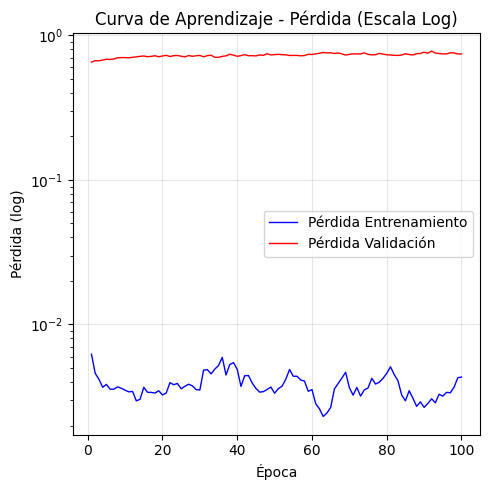


Resultados finales:
Pérdida final de entrenamiento: 0.0043
Pérdida final de validación: 0.7441
Mejor pérdida de validación: 0.6535 (época 1)


In [48]:

# Crear dataset para Marquez dataset completp
from sklearn.model_selection import train_test_split

# separo 65% train, 35% validacion
train_data, val_data = train_test_split(
    puntuacion_tokens_marquez, 
    test_size=0.35, 
    random_state=42
)

print(f"Dataset completo: {len(puntuacion_tokens_marquez)} sentences")
print(f"Entrenamiento: {len(train_data)} sentences ({len(train_data)/len(puntuacion_tokens_marquez)*100:.1f}%)")
print(f"Validación: {len(val_data)} sentences ({len(val_data)/len(puntuacion_tokens_marquez)*100:.1f}%)")

# datasets
dataset_train = MarquezDataset(data=train_data)
dataset_val = MarquezDataset(data=val_data)

# loaders
loader_train = DataLoader(dataset_train, batch_size=32, shuffle=True, collate_fn=marquez_collate_fn)
loader_val = DataLoader(dataset_val, batch_size=32, shuffle=False, collate_fn=marquez_collate_fn)


train_losses, val_losses = entrenar_modelo(modelo_unidireccional, loader_train, loader_val, 
                                         optimizer_unidireccional, criterion_unidireccional, cant_epochs=100)
# Curva de aprendizaje
plt.figure(figsize=(5, 5))
epochs = range(1, len(train_losses) + 1)
plt.semilogy(epochs, train_losses, 'b-', label='Pérdida Entrenamiento', linewidth=1)
plt.semilogy(epochs, val_losses, 'r-', label='Pérdida Validación', linewidth=1)
plt.title('Curva de Aprendizaje - Pérdida (Escala Log)')
plt.xlabel('Época')
plt.ylabel('Pérdida (log)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print(f"\nResultados finales:")
print(f"Pérdida final de entrenamiento: {train_losses[-1]:.4f}")
print(f"Pérdida final de validación: {val_losses[-1]:.4f}")
print(f"Mejor pérdida de validación: {min(val_losses):.4f} (época {val_losses.index(min(val_losses)) + 1})")
